In [95]:
#load and vis a few seqmented images in the images_CNN folder

import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import Image, ImageSequence
img_list = glob.glob('images_CNN/F?_im.TIF')+glob.glob('images_CNN/F??_im.TIF')
img_list = sorted(img_list)
mask_list = glob.glob('images_CNN/*mask.h5')
mask_list = sorted(mask_list)
fluo_gfp = glob.glob('images_CNN/*GFP_im.TIF')
fluo_gfp = sorted(fluo_gfp)
fluo_rfp = glob.glob('images_CNN/*RFP_im.TIF')
fluo_rfp = sorted(fluo_rfp)
print( len(img_list), len(mask_list) , len(fluo_gfp), len(fluo_rfp  )   )
dataset = {}
for i in range(len(img_list)):
    dataset[i] = { 'img': img_list[i], 'mask': mask_list[i], 'gfp': fluo_gfp[i], 'rfp': fluo_rfp[i]  }
print(dataset)


11 11 11 11
{0: {'img': 'images_CNN/F10_im.TIF', 'mask': 'images_CNN/F10_mask.h5', 'gfp': 'images_CNN/F10_GFP_im.TIF', 'rfp': 'images_CNN/F10_RFP_im.TIF'}, 1: {'img': 'images_CNN/F11_im.TIF', 'mask': 'images_CNN/F11_mask.h5', 'gfp': 'images_CNN/F11_GFP_im.TIF', 'rfp': 'images_CNN/F11_RFP_im.TIF'}, 2: {'img': 'images_CNN/F1_im.TIF', 'mask': 'images_CNN/F1_mask.h5', 'gfp': 'images_CNN/F1_GFP_im.TIF', 'rfp': 'images_CNN/F1_RFP_im.TIF'}, 3: {'img': 'images_CNN/F2_im.TIF', 'mask': 'images_CNN/F2_mask.h5', 'gfp': 'images_CNN/F2_GFP_im.TIF', 'rfp': 'images_CNN/F2_RFP_im.TIF'}, 4: {'img': 'images_CNN/F3_im.TIF', 'mask': 'images_CNN/F3_mask.h5', 'gfp': 'images_CNN/F3_GFP_im.TIF', 'rfp': 'images_CNN/F3_RFP_im.TIF'}, 5: {'img': 'images_CNN/F4_im.TIF', 'mask': 'images_CNN/F4_mask.h5', 'gfp': 'images_CNN/F4_GFP_im.TIF', 'rfp': 'images_CNN/F4_RFP_im.TIF'}, 6: {'img': 'images_CNN/F5_im.TIF', 'mask': 'images_CNN/F5_mask.h5', 'gfp': 'images_CNN/F5_GFP_im.TIF', 'rfp': 'images_CNN/F5_RFP_im.TIF'}, 7: {'i

In [ ]:
#augment dataset here



In [101]:

import skimage.measure as measure
import copy

def output_contours( m , cl , verbose = False):
    contours = measure.find_contours(m, .9)
    if verbose:
        plt.imshow(m)
        for n, contour in enumerate(contours):
            plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
        plt.show()

    #output contours of each mask to file
    #divide x and y coordinates by total image size
    #to get values between 0 and 1  
    #<class-index> <x1> <y1> <x2> <y2> ... <xn> <yn>
    lines = []
    for c in contours:
        coords = []
        for i in range(0,c.shape[0]):
            coords.append( float(c[i][0]) / m.shape[0] )
            coords.append( float(c[i][1]) / m.shape[1] )
        line = str(cl) + ' ' + ' '.join([str(c) for c in coords]) + '\n'
        lines.append(line)
    return lines

def split_mask(mask, crop = 1024):
    #custom encoding with 3 classes
    mask = mask[0:crop, 0:crop]
    mask1 = copy.deepcopy(mask)
    mask1[ (mask1 > 0) & (mask1 < 1000)] =  1
    mask1[mask1 > 1] = 0 

    mask2 = copy.deepcopy(mask)
    mask2[mask2 == 1] = 0
    mask2[ (mask2 > 1000) & (mask2 < 2000)] =  1
    mask2[mask2 > 1] = 0

    mask3 = copy.deepcopy(mask)
    mask3[mask3 == 1] = 0
    mask3[ (mask3 >= 2000) ] =  1
    mask3[mask3 > 1] = 0
    return mask1, mask2, mask3

def mask2contourfile( mask , outputfile , verbose = False):
    m1, m2, m3 = split_mask(mask)
    lines = output_contours(m1, 0 , verbose = verbose)
    lines += output_contours(m2, 1, verbose = verbose)
    lines += output_contours(m3, 2, verbose = verbose)
    
    with open(outputfile, 'w') as f:
        for l in lines:
            f.write(l)
    return  outputfile


In [102]:
#clean finaldataset folder
import shutil
overwite = True
if overwite:
    try:
        shutil.rmtree('./datasets/')
    except:
        pass
    os.mkdir('./datasets/')
    os.mkdir('./datasets/train')
    os.mkdir('./datasets/train/images/')
    os.mkdir('./datasets/train/labels/')
    
    os.mkdir('./datasets/test')
    os.mkdir('./datasets/test/images/')
    os.mkdir('./datasets/test/labels/')
    
    os.mkdir('./datasets/val/')
    os.mkdir('./datasets/val/images')
    os.mkdir('./datasets/val/labels')


In [103]:
#stack equivalent frames together from img, gfp and rfp and transform them to a jpg image
import cv2
import numpy as np
import os
import tqdm

verbose = True

def yield_frames(img,crop=1024 , verbose = False):
    for i, page in enumerate(ImageSequence.Iterator(img)):
        if verbose == True:
            plt.imshow(np.array(page))
            plt.show()
        page = np.array(page)[0:crop, 0:crop]
        yield page
count = 0

for sample in dataset:
    maskfile = dataset[sample]['mask']
    maskh5 = h5py.File(maskfile, 'r')
    for group in maskh5.keys():
        for frame in maskh5[group]:
            mask = np.array( maskh5[group][frame] ,  dtype = np.uint16 )
            if np.sum(mask) > 0 :
                print( group, frame)
                print(np.unique(mask) )
                if verbose == True:
                    plt.imshow(mask)
                    plt.show()
                converted = mask2contourfile(mask, maskfile +'converted.txt' , verbose = verbose)
                dataset[sample]['mask_poly'] = converted
                break

    print('loading img')
    img = Image.open(dataset[sample]['img'])
    img = [frame for frame in yield_frames(img,verbose=verbose)]
    print('loading gfp')

    gfp = Image.open(dataset[sample]['gfp'])
    gfp = [frame for frame in yield_frames(gfp,verbose=verbose)]
    
    print('loading rfp')
    rfp = Image.open(dataset[sample]['rfp'])
    rfp = [frame for frame in yield_frames(rfp,verbose=verbose)]

    #stack the frames together
    for i in tqdm.tqdm(range(len(img))):
        im = np.stack([img[i], gfp[i], rfp[i]], axis=-1)
        im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        cv2.imwrite('./datasets/train/images/img_'+str(count)+'.png', im )
        #save the correct mask file
        shutil.copyfile(dataset[sample]['mask_poly'], './datasets/train/labels/img_'+str(count)+'.txt' )
        count += 1

FOV0 T5
[   0    1    2    3    4 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1020 1021 1023 1024 1025 1026 1027 1028 1029 2001 2002 2003]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.26it/s]


FOV0 T5
[   0 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 2001 2002]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.08it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7    8    9   10   11   12 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042 1043 1044 1045 1046 1047 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.18it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7    8    9   10   13   14   15   16   17   18 1001 1002 1003 1004 1007 1008 1009 1010 1013 1014 1015 1016 1017 1018 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042 1043 1044 1046 1047 1048 1049 1050 1051 1052
 1053 1054 1055 1056 1059 1060 1061 1062 1063 1064 1065 1066 1067 1069 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083 1084 2001 2002 2003 2004 2005 2006]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.11it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019 2020]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.10it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24 1001 1003 1004 1005 1006 1007 1009 1010 1011 1012 1013 1014 1015 1017 1018 1019 1020 1021 1022 1023 1026 1027 1028 1029 1030 1031 1032 1033 1034 1036 1037 1038 1039 1040 1042 1043 1044 1045
 1046 1047 1051 1052 1053 1055 1056 1057 1058 1059 1061 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.17it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7 1001 1002 1003 1004 1005 1006 1007 1008 1012 1013 1015 1016 1017 1018 1019 1020 1021 1022 1024 1025 1026 1027 1028 1029 1031 1032 1033 1034 1035 2001 2002 2003 2004 2005 2006]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.25it/s]


FOV0 T5
[   0    1    2    3    4 1001 1002 1003 1004 1005 1007 1008 1009 1010 2001]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.25it/s]


FOV0 T5
[   0    1 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.31it/s]


FOV0 T5
[   0    1    2    3    4    5 1001 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1030 1032 1033 1034 1035 1036 1037 2001 2002 2003]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.08it/s]


FOV0 T5
[   0    1    2    3    4 1001 1002 1003 1004 1005 1006 1007 1008 1009 1011 1012 1013 1014 1015 1016 1018 1019 1021 1022 1023 1024 1025 1026 2001 2002 2003]
loading img
loading gfp
loading rfp


100%|██████████| 7/7 [00:00<00:00,  8.25it/s]


loading gfp
loading rfp


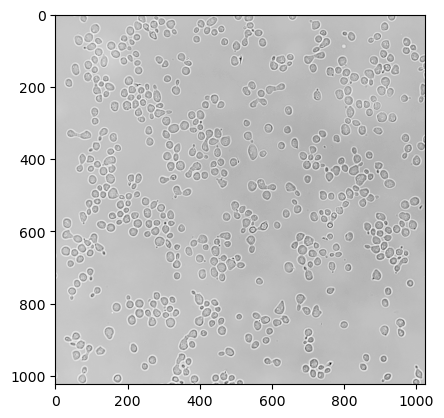

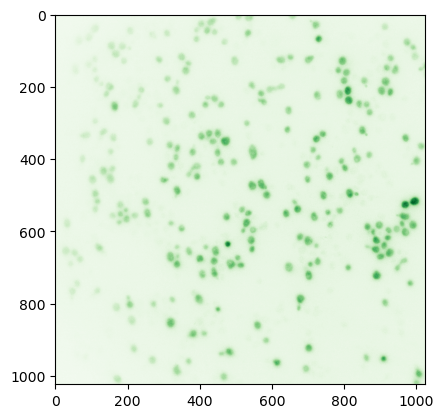

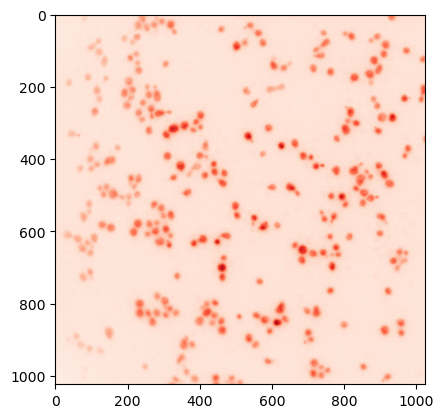

In [127]:
check_example = True
import matplotlib.pyplot as plt
%matplotlib inline
if check_example == True:
    img = Image.open(dataset[0]['img'])
    img = [frame for frame in yield_frames(img,verbose=False)]
    print('loading gfp')

    gfp = Image.open(dataset[0]['gfp'])
    gfp = [frame for frame in yield_frames(gfp,verbose=False)]
    
    print('loading rfp')
    rfp = Image.open(dataset[0]['rfp'])
    rfp = [frame for frame in yield_frames(rfp,verbose=False)]

    plt.imshow( img[0] , cmap = 'Greys')
    plt.show()
    
    plt.imshow( gfp[0] , cmap = 'Greens')
    plt.show()
    
    plt.imshow( rfp[0] , cmap = 'Reds')
    plt.show()
    


In [ ]:
#move a fraction of the training data and corresponding labels to val
import random
import shutil
import os
files = os.listdir('./datasets/train/images/')
random.shuffle(files)
val_files = files[:int(len(files)*.1)]
for f in val_files:
    shutil.move('./datasets/train/images/'+f, './datasets/val/images/'+f)
    shutil.move('./datasets/train/labels/'+f.replace('.png', '.txt'), './datasets/val/labels/'+f.replace('.png', '.txt'))

    
files = os.listdir('./datasets/train/images/')
random.shuffle(files)

test_files = files[:int(len(files)*.1)]
for f in test_files:
    shutil.move('./datasets/train/images/'+f, './datasets/test/images/'+f)
    shutil.move('./datasets/train/labels/'+f.replace('.png', '.txt'), './datasets/test/labels/'+f.replace('.png', '.txt'))

In [ ]:
#data augment the images and masks
#move files into train and test folders

In [ ]:
#create traininging yaml file for the dataset

outyaml = """
train: train
val: val
test: test

names: 
    0: f
    1: h
    2: l
"""

with open('./dataset.yaml', 'w') as f:
    f.write(outyaml)


In [ ]:
from ultralytics import YOLO

modelpath = 'yolov8n-seg_yfusion.pt'

train = True

#if os.path.exists(modelpath) :
    #load the model
#    model = YOLO(modelpath)
#else:
    #train the model
model = YOLO("yolov8n-seg.pt")

if train == True:
    results = model.train(
            batch=1,
            device="cpu",
            data='./dataset.yaml',
            epochs=8,
            imgsz=1024,
            
        )

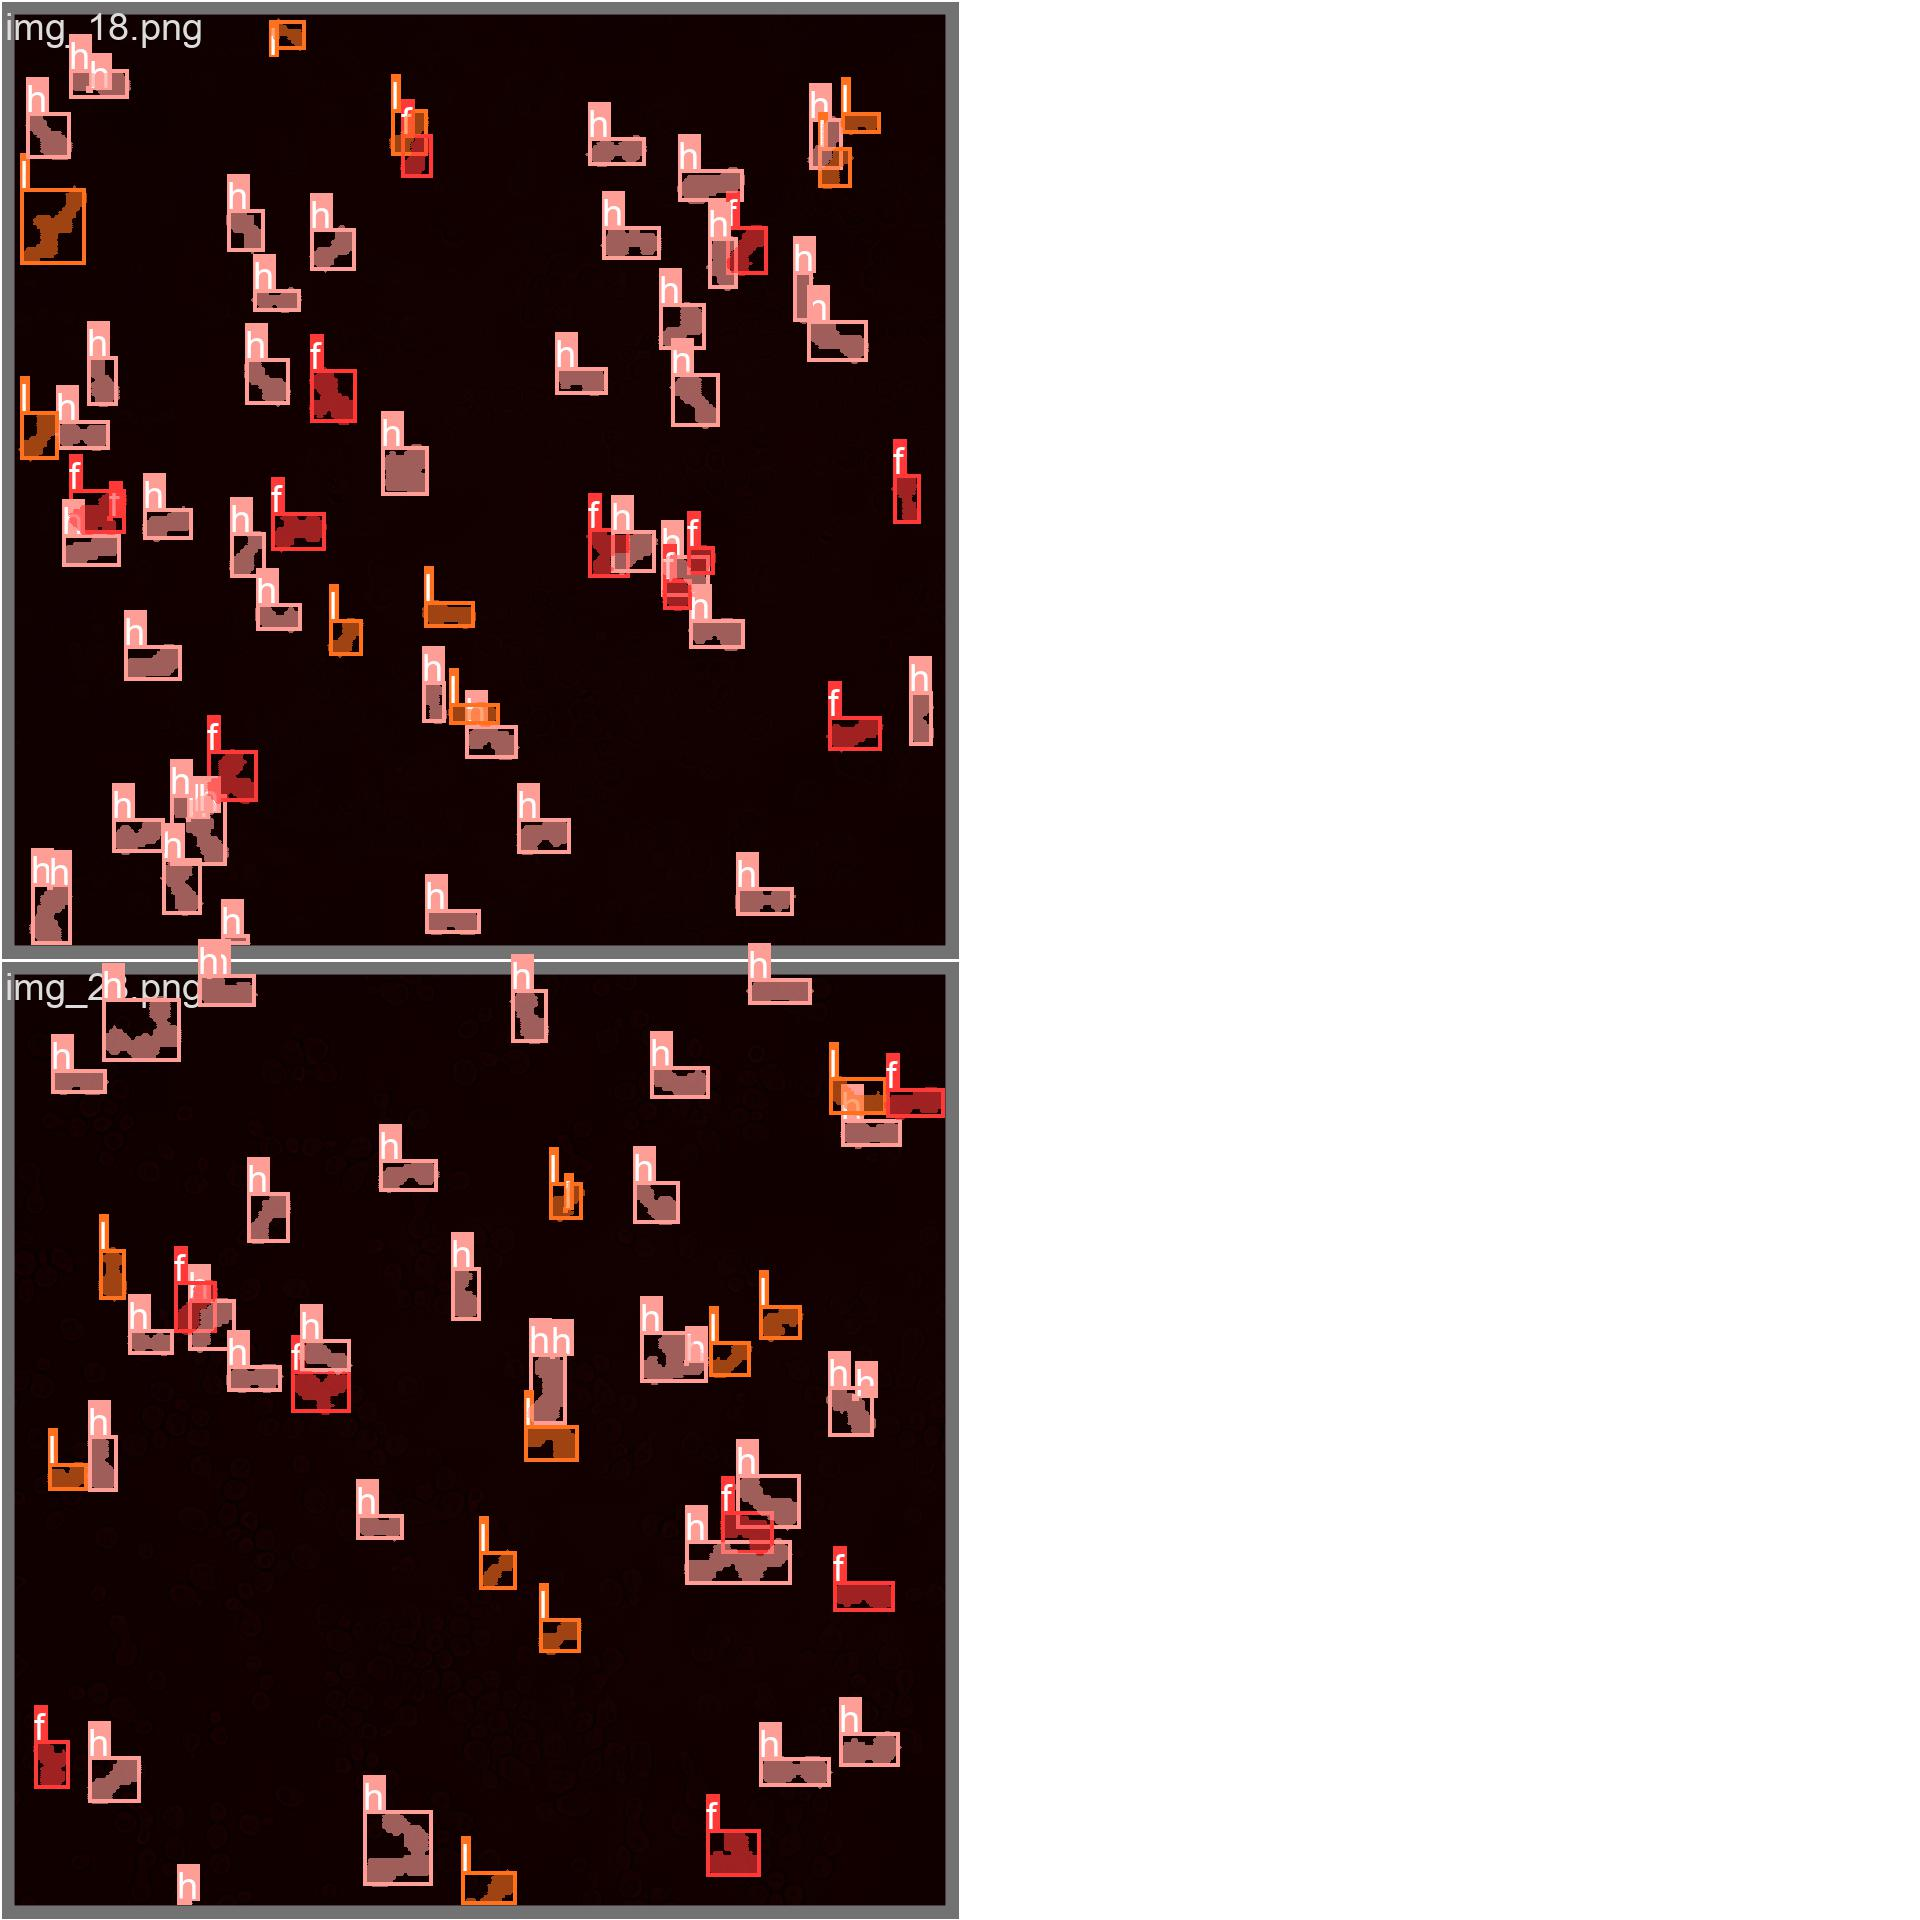

In [104]:
from IPython.display import Image as show_image
show_image(filename="runs/segment/train5/train_batch0.jpg")


from IPython.display import Image as show_image
show_image(filename="runs/segment/train5/val_batch0_labels.jpg")

In [105]:
#save model
model.save('yolov8n-seg_yfusion.pt')

In [ ]:
from ultralytics import YOLO


In [120]:
#visualize predicitions for the validation set

import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt



my_model = YOLO('runs/segment/train5/weights/best.pt')
results = list(my_model('datasets/test/images/img_5.png', conf=0.0128))

result = results[0]


image 1/1 /work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/segmentation_fluo/datasets/test/images/img_5.png: 1024x1024 (no detections), 493.1ms
Speed: 3.1ms preprocess, 493.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)


In [121]:
print(results)

[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'f', 1: 'h', 2: 'l'}
obb: None
orig_img: array([[[ 0,  0, 27],
        [ 0,  0, 27],
        [ 0,  0, 26],
        ...,
        [ 0,  0, 28],
        [ 0,  0, 28],
        [ 0,  0, 27]],

       [[ 0,  0, 27],
        [ 0,  0, 27],
        [ 0,  0, 26],
        ...,
        [ 0,  0, 27],
        [ 0,  0, 28],
        [ 0,  0, 27]],

       [[ 0,  0, 26],
        [ 0,  0, 27],
        [ 0,  0, 27],
        ...,
        [ 0,  0, 28],
        [ 0,  0, 28],
        [ 0,  0, 28]],

       ...,

       [[ 0,  0, 26],
        [ 0,  0, 26],
        [ 0,  0, 25],
        ...,
        [ 0,  0, 26],
        [ 0,  0, 27],
        [ 0,  0, 27]],

       [[ 0,  0, 26],
        [ 0,  0, 26],
        [ 0,  0, 25],
        ...,
        [ 0,  0, 27],
        [ 0,  0, 27],
        [ 0,  0, 26]],

       [[ 0,  0, 25],
        [ 0,  0, 26],
        [ 0,  0, 26]

In [ ]:
from IPython.display import Image as show_image
show_image(filename="runs/segment/train42/val_batch0_labelsYOLOjpg")

show_image(filename="runs/segment/train42/MaskP_curve.png")

show_image(filename="runs/segment/train42/results.png")



In [ ]:
#image augmentation for training

import cv2
import random
import numpy as np

def random_rotation(image, mask, angle_range):
    angle = random.uniform(-angle_range, angle_range)
    image = Image.fromarray(image)
    mask = Image.fromarray(mask)
    image = image.rotate(angle)
    mask = mask.rotate(angle)
    return np.array(image), np.array(mask)

def random_flip(image, mask):
    if random.random() > 0.5:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)
    return image, mask

def random_crop(image, mask, crop_size):
    h, w, _ = image.shape
    crop_h, crop_w = crop_size
    top = np.random.randint(0, h - crop_h)
    left = np.random.randint(0, w - crop_w)
    bottom = top + crop_h
    right = left + crop_w
    image = image[top:bottom, left:right]
    mask = mask[top:bottom, left:right]
    return image, mask

def random_augmentation(image, mask, angle_range, crop_size):
    image, mask = random_rotation(image, mask, angle_range)
    image, mask = random_flip(image, mask)
    image, mask = random_crop(image, mask, crop_size)
    return image, mask

#resize to original size
def resize(image, mask, size):
    image = cv2.resize(image, size)
    mask = cv2.resize(mask, size)
    return image, mask

#apply augmentation and then resize to original size
def augment_and_resize(image, mask, angle_range, crop_size, size):
    image, mask = random_augmentation(image, mask, angle_range, crop_size)
    image, mask = resize(image, mask, size)
    return image, mask



frames	framee	cuttop	cutbttm	cutleft	cutrght
0	6	1	1040	1	1392



In [ ]:
#augment dataset and dump to disk in pt format


In [ ]:
#retrain yolo segmentation net on the new data

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = Image.open(self.dataset[idx]['img'])
        maskfile = h5py.File(self.dataset[idx]['mask'], 'r')
        
        for group in maskfile:
            for frame in maskfile[group]:
                mask = np.array( maskfile[group][frame] ,  dtype = np.uint16 )
                if np.sum(mask) > 0 :
                    mask = mask
        
        if self.transform:
            img = self.transform(img)
        
        return img, mask

transform = transforms.Compose([ transforms.ToTensor() ])
dataset = CustomDataset(dataset, transform=transform)

train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#traininig loop
num_epochs = 10
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (i+1) % 10 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

In [ ]:
#predict on the test set
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        print(outputs.shape, targets.shape)
        break


#visualize the results
import matplotlib.pyplot as plt
import numpy as np
import torchvision

for i in range(2):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(inputs[i].permute(1, 2, 0)))
    plt.title('Input')
    plt.subplot(1, 2, 2)
    plt.imshow(targets[i].squeeze(), cmap='gray')
    plt.title('Target')
    plt.show()
    plt.figure(figsize=(20, 10))
    plt.imshow(outputs[i].squeeze(), cmap='gray')
    plt.title('Output')
    plt.show()
    break